In [1]:
import pandas as pd
import os
import subprocess
import zipfile
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import pylab 
import scipy.stats as st
import pymc3  as pm
import seaborn as sns
import arviz as az
from sklearn.preprocessing import scale
from matplotlib import rcParams
from scipy import interpolate
import matplotlib.cm as cm


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
wave = np.array([412,443,488,531,547,555,667,678])
λ = np.array([412, 443, 469, 488, 531, 547, 555, 645, 667, 678], dtype=np.int32)


In [3]:
ndata = len(wave)
Lt_names = ['Lt_%d' % wv for wv in wave]
Lr_names = ['Lr_%d' % wv for wv in wave]
La_names = ['La_%d' % wv for wv in wave]
TLg_names = ['TLg_%d' % wv for wv in wave]
tLf_names = ['tLf_%d' % wv for wv in wave]
polcor_names = ['polcor_%d' % wv for wv in wave]
brdf_names = ['brdf_%d' % wv for wv in wave]
Rrs_mob_names = ['Rrs_mob_%d' % wv for wv in wave]
Rrs_aqua_names = ['Rrs_aqua_%d' % wv for wv in wave]

chl_names = ['chlor_a_%d' % wv for wv in wave]
relaz_names = ['relaz_%d' % wv for wv in wave]
scat_names = ['scattang_%d' % wv for wv in wave]
glint_names = ['glint_coef_%d' % wv for wv in wave]

Lw_names = ['Lw_%d' % wv for wv in wave]
tg_sol_names = ['tg_sol_%d' % wv for wv in wave]
tg_sen_names = ['tg_sen_%d' % wv for wv in wave]
aot_names = ['aot_%d' % wv for wv in wave]

tsol_names = ['t_sol_%d' % wv for wv in wave]
tsen_names = ['t_sen_%d' % wv for wv in wave]
water_vapor_names = ['water_vapor_%d' % wv for wv in wave]
solz_names = ['solz_%d' % wv for wv in wave]
senz_names = ['senz_%d' % wv for wv in wave]
angstrom_names = ['angstrom_%d' % wv for wv in wave]
epsilon_names = ['epsilon_%d' % wv for wv in wave]
windspeed_names = ['windspeed_%d' % wv for wv in wave]
humidity_names = ['humidity_%d' % wv for wv in wave]
pressure_names = ['pressure_%d' % wv for wv in wave]
ozone_names = ['ozone_%d' % wv for wv in wave]


In [4]:
df = np.load('moby_df', allow_pickle=True)

In [5]:
ndf = df.dropna()
dfn = (ndf - ndf.mean())/ndf.std()

In [25]:
indx = np.arange(0,len(wave))

with pm.Model() as pooled_model_ST_MLR:
    hyp_α_sd = pm.HalfCauchy('hyp_α_sd', 1)
    hyp_β_sd = pm.HalfCauchy('hyp_β_sd', 1)
    
    # Independent parameters for each county
    α = pm.Normal('α', 0, sd=hyp_α_sd, shape=ndata)
    β0 = pm.Normal('β0', 0, sd=hyp_β_sd, shape=ndata)
    β1 = pm.Normal('β1', 0, sd=hyp_β_sd, shape=ndata)
    β2 = pm.Normal('β2', 0, sd=hyp_β_sd, shape=ndata)
    β3 = pm.Normal('β3', 0, sd=hyp_β_sd, shape=ndata)
    β4 = pm.Normal('β4', 0, sd=hyp_β_sd, shape=ndata)
#     β5 = pm.Normal('β5', 0, sd=hyp_β_sd, shape=ndata)
    
    # Model DOF
    ν = pm.Exponential('ν', 1/30)

    # Model error
    σ = pm.HalfCauchy('σ', 1)
    
#     Rrs_est = α[indx] + β0[indx]*dfn[Rrs_mob_names] + β1[indx]*dfn[brdf_names]  +\
#                β2[indx]*dfn[windspeed_names] + β3[indx]*dfn[glint_names]
    
#     Rrs_est = α[indx] + β0[indx]*dfn[Rrs_mob_names] + β1[indx]*dfn[solz_names]  +\
#                β2[indx]*dfn[senz_names] + β3[indx]*dfn[relaz_names]
    
#     Rrs_est = α[indx] + β0[indx]*dfn[Rrs_mob_names] + β1[indx]*dfn[windspeed_names]  +\
#                β2[indx]*dfn[water_vapor_names] + β3[indx]*dfn[humidity_names] +\
#                β4[indx]*dfn[pressure_names] + β5[indx]*dfn[ozone_names]

#     Rrs_est = α[indx] + β0[indx]*dfn[Rrs_mob_names] + β1[indx]*dfn[angstrom_names]  +\
#                β2[indx]*dfn[epsilon_names] + β3[indx]*dfn[aot_names]+ β4[indx]*dfn[polcor_names]

    Rrs_est = α[indx] + β0[indx]*dfn[Rrs_mob_names] + β1[indx]*dfn[Lr_names]  +\
               β2[indx]*dfn[La_names] + β3[indx]*dfn[tLf_names]+ β4[indx]*dfn[TLg_names]

#     Rrs_est = α[indx] + β0[indx]*dfn[Rrs_mob_names] + β1[indx]*dfn[tsol_names]  +\
#                β2[indx]*dfn[tsen_names] + β3[indx]*dfn[tg_sol_names]+ β4[indx]*dfn[tg_sen_names]


    # Data likelihood
    likelihood = pm.StudentT('Rrs_est', mu=Rrs_est, sd=σ, nu=ν, observed=dfn[Rrs_aqua_names])
    
with pooled_model_ST_MLR:
    trace_hc_mlr = pm.sample(2000,tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, ν, β4, β3, β2, β1, β0, α, hyp_β_sd, hyp_α_sd]
Sampling 4 chains, 58 divergences: 100%|██████████| 20000/20000 [00:36<00:00, 546.72draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7050251194989119, but should be close to 0.8. Try to increase the number of tuning steps.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


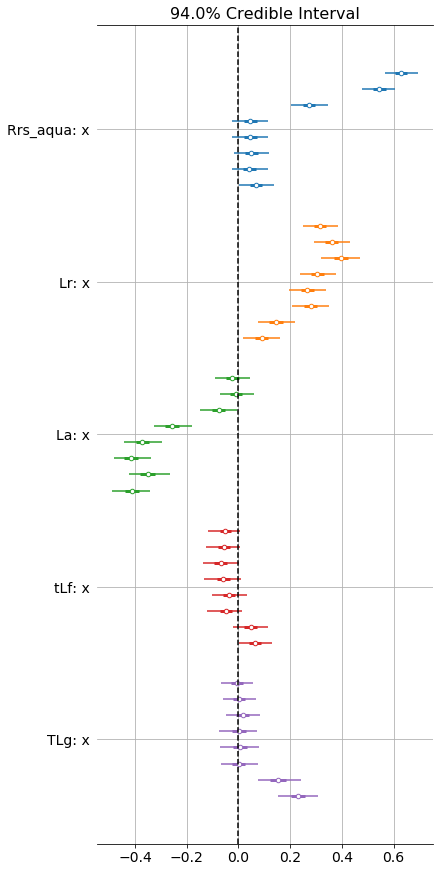

In [27]:
# mnames =  [ 'Rrs_aqua','brdf', 'windspeed', 'glint_coeff']
# mnames =  ['Rrs_aqua','solz', 'senz', 'relaz']
# mnames =  ['Rrs_aqua','windspeed', 'water_vapor', 'humidity', 'pressure', 'ozone']
# mnames =  ['Rrs_aqua','angstrom', 'epsilon', 'aot', 'polcor']
mnames =  ['Rrs_aqua','Lr', 'La', 'tLf', 'TLg']
# mnames =  ['Rrs_aqua','tsol', 'tsen', 'Tgsol', 'Tgsen']


ax = az.plot_forest([np.flipud(trace_hc_mlr['β0'].T), np.flipud(trace_hc_mlr['β1'].T),
               np.flipud(trace_hc_mlr['β2'].T), np.flipud(trace_hc_mlr['β3'].T)
                ,np.flipud(trace_hc_mlr['β4'].T), 
#                      np.flipud(trace_hc_mlr['β5'].T)    
                    ], 
               model_names=mnames)

# az.plot_forest([np.flipud(trace_hc_mlr['β0'].T), ], model_names=[ 'glint',])
ax[0].axvline(0, color='k', ls='--');
ax[0].grid()
# plt.savefig('forest_plot_at_surface_aqua.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('forest_plot_geom_aqua.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('forest_plot_ancillary_data_aqua.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('forest_plot_aerosol_aqua.pdf', dpi=300, bbox_inches='tight')
plt.savefig('forest_plot_radiances_aqua.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('forest_plot_transmittances.pdf', dpi=300, bbox_inches='tight')

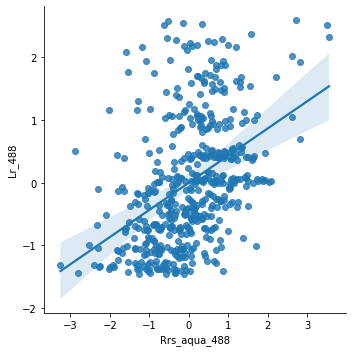

In [59]:
sns.lmplot('Rrs_aqua_488', 'Lr_488', dfn, ci=100)
# plt.xlim([0,0.01])

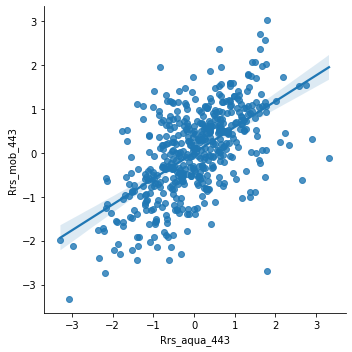

In [19]:
sns.lmplot('Rrs_aqua_443', 'Rrs_mob_443', dfn, ci=95)

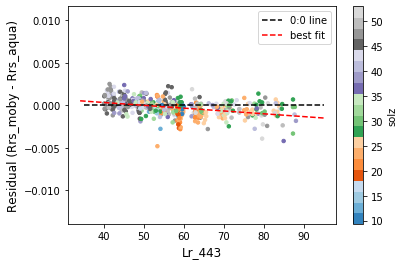

<Figure size 432x288 with 0 Axes>

In [237]:
l= 443
y = ndf['Rrs_diff_' + np.str(l)]
x = ndf['Lr_' + np.str(l)].values
z = ndf['solz_' + np.str(l)]

cm = plt.cm.get_cmap('tab20c')
sc = plt.scatter(x, y, c=z, vmin=z.min(), vmax=z.max(), s=12, cmap=cm)
scb = plt.colorbar(sc, label='solz')

plt.ylabel('Residual (Rrs_moby - Rrs_aqua)', fontsize=12)
plt.xlabel('Lr_' + np.str(l), fontsize=12)
plt.plot([35,95], [0,0], '--k', label= '0:0 line')
plt.plot(xx,yy, '--r', label= 'best fit')
# plt.xlim([35,95])
plt.legend()
plt.show()
plt.savefig('Residual_Lr_443.pdf', dpi=300,  bbox_inches='tight')


In [203]:
from scipy import stats

In [210]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

In [231]:
xx = np.linspace(34,95, 100)
yy = intercept + slope*xx